In [1]:
!pip install kaggle
!pip install pandas
!pip install sklearn
!pip install tensorflow
!pip install scikit-image
!pip install keras
!pip install seaborn 
!pip install matplotlib
!pip install opencv-python
!pip install medpy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.5 MB 2.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 22.2 MB 879 kB/s eta 0:00:01
     |████████████████████████████████| 303 kB 990 kB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 6.6 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=f3f69679c059c303a44dfc0e70f5f34c76ef2ae15f6582e52b100b4c56783432
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 12.4 MB 6.6 MB/s et

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!ls /root/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s "AttentionLayer241"

In [ ]:
!kaggle datasets download attentionlayer241/celeba-spoof-for-face-antispoofing

In [36]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))

Total: 196 GiB
Used: 150 GiB
Free: 45 GiB


In [4]:
# Import the famous library from Python 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# RUN apt-get update && apt-get install -y python3-opencv
# RUN pip install opencv-python
import cv2
import matplotlib.pyplot as plt


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# %cd /kaggle/working
# %cd ../input/celeba-spoof-for-face-antispoofing
# !pwd

In [5]:
def get_ratio_bbox_and_image(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_h, real_w, _ = img.shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image


def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) # bbox[0]
    y1 = int(int(bbox1)*(float(real_h) / 224)) # bbox[1]
    w1 = int(int(bbox2)*(float(real_w) / 224)) # bbox[2]
    h1 = int(int(bbox3)*(float(real_h) / 224)) # bbox[3]
    return x1, y1, w1, h1


def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, 
                                                   bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
#     print(f"bound_box_path: {bound_box_path}")
#     print(f'bound box: {bbox}')
    real_w = img.shape[1]
    real_h = img.shape[0]
#     print(f'read_w = {img.shape[1]}')
#     print(f'read_h = {img.shape[0]}')
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
#     print(f'x1={x1}, y1={y1}, w1={w1}, and h1={h1}')
    return x1, y1, w1, h1, img, real_w, real_h

In [9]:
# Live Storage
original_cropped_storage = []
padding_cropped_storage = []
img_names = []
original_cropped_labels = []
padding_cropped_labels = []

count_live = 0
count_spoof = 0
dim = (90, 90)
count_limit_live = 10000
count_limit_spoof = 10000

#rootdir_train = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'
rootdir_train = 'celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'
for file in os.listdir(rootdir_train):
#     file = '1'
    # file is 1, 1000, ..... 10029,...... => Name of folder 
    d = os.path.join(rootdir_train, file)
    if os.path.isdir(d):
        for e in os.listdir(d):
            # e is "live" of "spoof"
            imgs_path = d + '/' + e + '/'
#             print(imgs)
            for img_path in os.listdir(imgs_path):
#                 print(img_path)
#                 imgs_path = '000184.jpg'
                if (img_path.endswith(".jpg")):
                    full_img_path = imgs_path + img_path
#                     print('full_img_path: {full_img_path}')
                    bound_box_path = full_img_path[0:-4] + '_BB.txt'
#                     print(f'bound_box_path: {bound_box_path}')
                    x1, y1, w1, h1, img, real_w, real_h = read_crop_img_with_bbox(full_img_path, bound_box_path)
                    ratio_bbox_and_image = get_ratio_bbox_and_image(full_img_path, bound_box_path)
#                     print(f'ratio_bbox_and_image = {ratio_bbox_and_image}')
                    x1_padding, y1_padding, w1_padding, h1_padding = get_padding_bbox_indices(x1, y1, w1, h1, 
                                                                                              real_w, real_h,
                                                                                              ratio_bbox_and_image)
#                     print(x1_padding, y1_padding, w1_padding, h1_padding)
#                     plt.imshow(img[y1_padding:y1+h1_padding,
#                                    x1_padding:x1+w1_padding])
                    padding_img = img[y1_padding:y1+h1_padding, x1_padding:x1+w1_padding]
                    try:
                        if (e == 'live' and count_live >= count_limit_live) or (e == 'spoof' and count_spoof >= count_limit_spoof):
                            continue
                        resized_padding_img = cv2.resize(padding_img, dim, interpolation = cv2.INTER_AREA)
                        padding_cropped_storage.append(resized_padding_img)
                        if e == 'live':
                            count_live = count_live + 1
                            padding_cropped_labels.append(1)
                        elif e == 'spoof':
                            count_spoof = count_spoof + 1
                            padding_cropped_labels.append(0)
                    except:
                        continue
                        
#                     original_img = img[y1:y1+h1,x1:x1+w1]
#                     try: 
#                         resized_original_img= cv2.resize(original_img, dim, interpolation = cv2.INTER_AREA)
#                         original_cropped_storage.append(resized_original_img)
#                         if e == 'live':
#                             count_live = count_live + 1
#                             original_cropped_labels.append(1)
#                         elif e == 'spoof':
#                             count_spoof = count_spoof + 1
#                             original_cropped_labels.append(0)
#                     except:
#                         continue
                    img_names.append(img_path)

#                     plt.imshow(img)
#                     plt.imshow(img[y1:y1+h1,x1:x1+w1])
#                     print(f'count_live: {count_live}')
#                     print(f'count_spoof: {count_spoof}')
                    if (count_live == count_limit_live and e == 'live') or (count_spoof == count_limit_spoof and e == 'spoof'):
                        break
#                 if count_live == count_limit_live and count_spoof == count_limit_spoof:
#                     break
            if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
                break
    if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
        print("DONE Extracting ")
        break


DONE Extracting 


### Saving the data in the NPZ file

In [10]:
# Save the numpy to NUMPYZ 
X = np.asarray(padding_cropped_storage)
y = np.asarray(padding_cropped_labels)
np.savez('anti_spoofing_data.npz', X, y)
print("DONE SAVING DATA WITH NPZ")

DONE SAVING DATA WITH NPZ


### Checking the number of Live Samples and Spoof Samples after extracting 

In [11]:
anti_spoofing_data = np.load('anti_spoofing_data.npz')
X, y = anti_spoofing_data['arr_0'], anti_spoofing_data['arr_1']
temp = set(y)
check_live_label = 0
check_spoof_label = 0
for i in y: 
    if i == 1:
        check_live_label += 1
    elif i == 0:
        check_spoof_label += 1
print(f"There are 2 classes including number of live is {check_live_label} and number of spoof is {check_spoof_label}")

There are 2 classes including number of live is 10000 and number of spoof is 10000


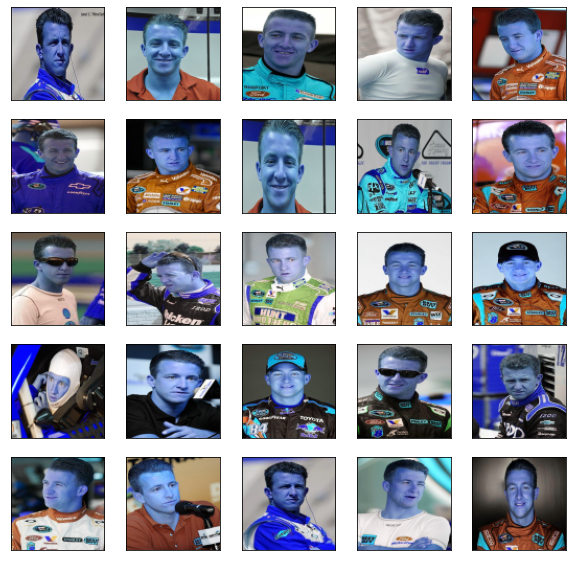

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
#     plt.imshow(original_cropped_storage[i])
    plt.imshow(X[i])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## SKlearn used for Splitting Training and Testing dataset

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# X = np.asarray(padding_cropped_storage)
# y = np.asarray(padding_cropped_labels)
print(X.shape)
print(y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.3, random_state=42)
print(f'Training dataset size of X_train: {len(X_train)}')
print(f'Testing dataset size of X_test: {len(X_test)}')
print(f'Validation dataset size of X_valid: {len(X_valid)}')
print(f'Testing dataset size of y_train: {len(y_train)}')
print(f'Testing dataset size of y_test: {len(y_test)}')
print(f'Testing dataset size of y_valid: {len(y_valid)}')

(20000, 90, 90, 3)
(20000,)
Training dataset size of X_train: 14000
Testing dataset size of X_test: 1800
Validation dataset size of X_valid: 4200
Testing dataset size of y_train: 14000
Testing dataset size of y_test: 1800
Testing dataset size of y_valid: 4200


## ===========================================================================================

## Read JSON file 

In [ ]:
# rootdir_train_json = '../input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/train_label.json'

# patients_df = pd.read_json(rootdir_train_json)
# patients_df.head()
# patients_df.iloc[:,0:19]

### Build a simple CNN Model for training, validating and testing

In [16]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(90,90, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# X_train, X_test, y_train, y_test
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid))
model.save("./my_model.h5") 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 88, 88, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 23104)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(90,90, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 88, 88, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [5]:
model.load_weights('C:/Users/user/Downloads/my_model.h5')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 88, 88, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

57/57 - 0s - loss: 0.9278 - accuracy: 0.9539


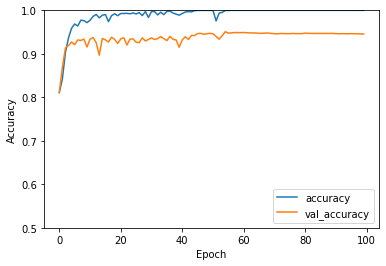

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [21]:
X_test.shape

(1800, 90, 90, 3)

In [22]:
y_test.shape

(1800,)

In [24]:
y_pred_test = model.predict(X_test)
y_pred_test.shape

(1800, 2)

In [25]:
y_pred = np.argmax(y_pred_test,axis=1)

In [26]:
y_pred.shape

(1800,)

In [27]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       907
           1       0.97      0.94      0.95       893

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



In [33]:
from tensorflow.keras.utils import to_categorical
y_test_dummy = to_categorical(y_test)
y_pred_dummy = to_categorical(y_pred)

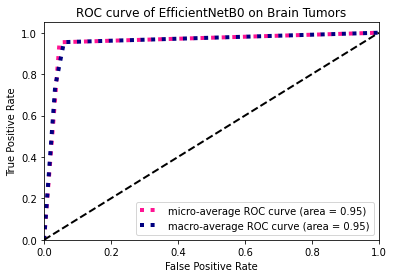

In [35]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as m
n_classes=2
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummy[:, i], y_pred_dummy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_dummy.ravel(), y_pred_dummy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of EfficientNetB0 on Brain Tumors')
plt.legend(loc="lower right")
plt.show()